<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

/tmp/ipython-input-1390815340.py:61: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


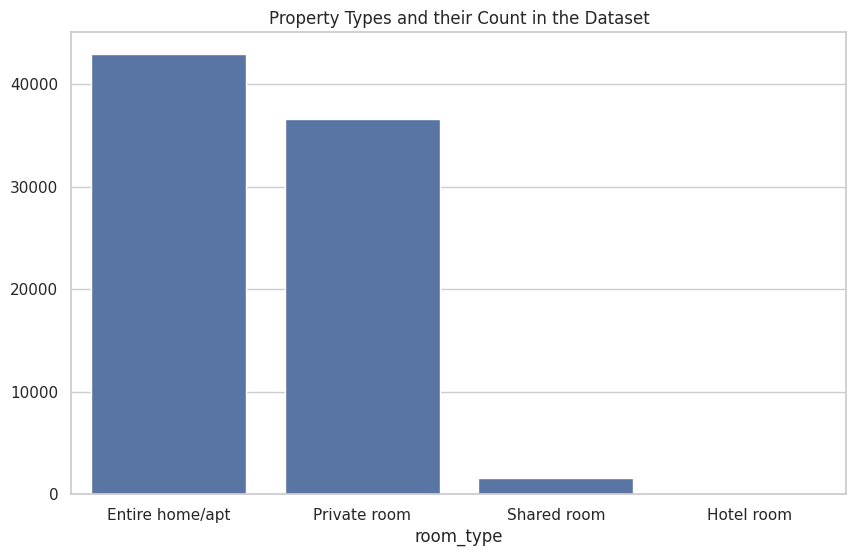

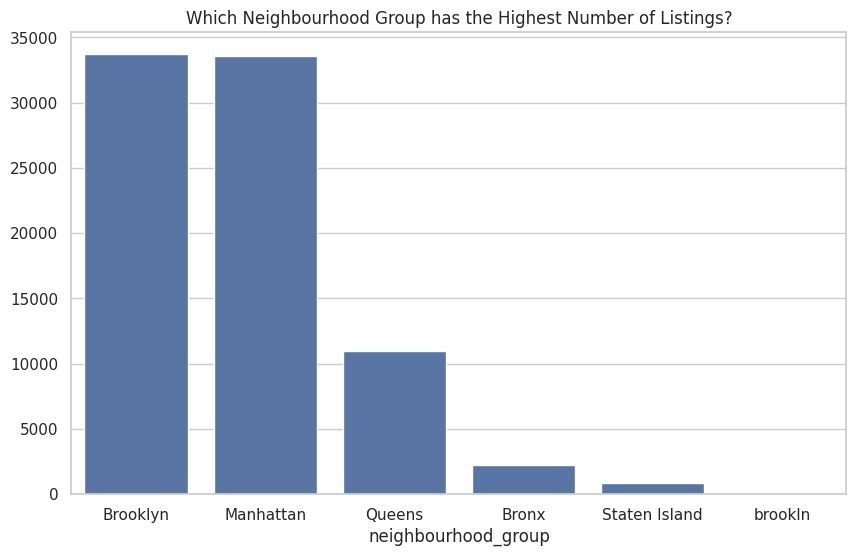

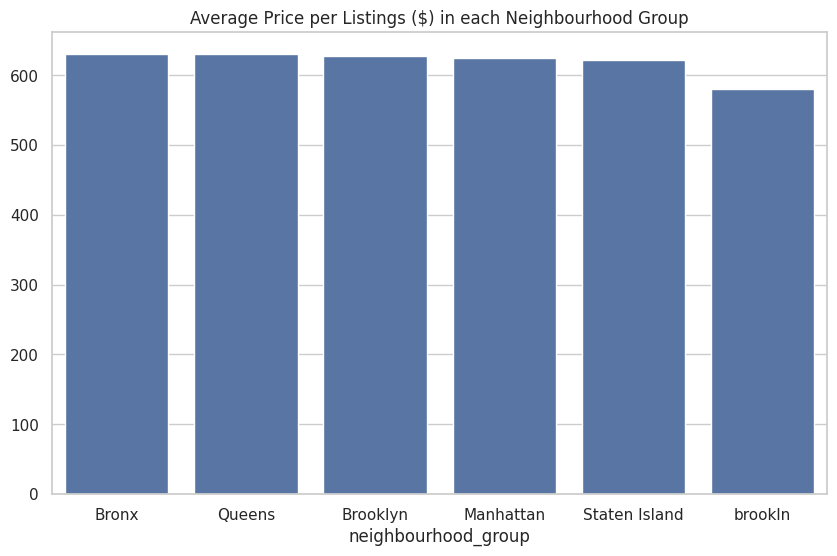

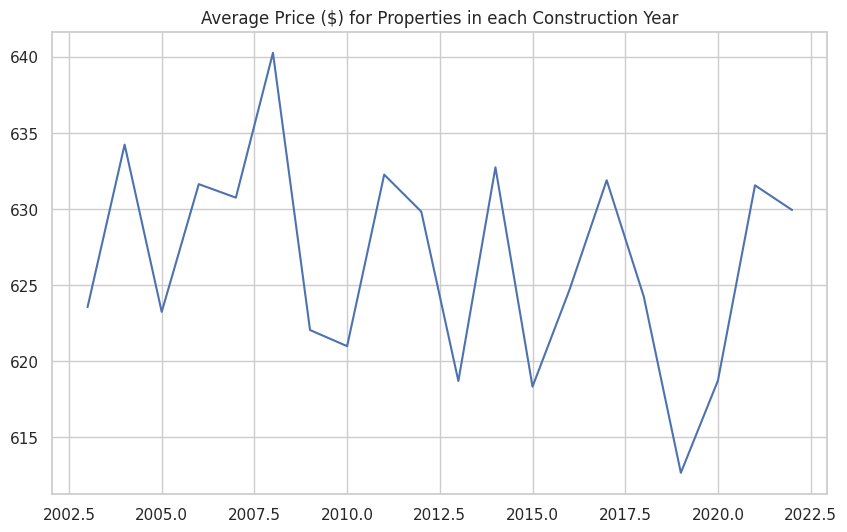

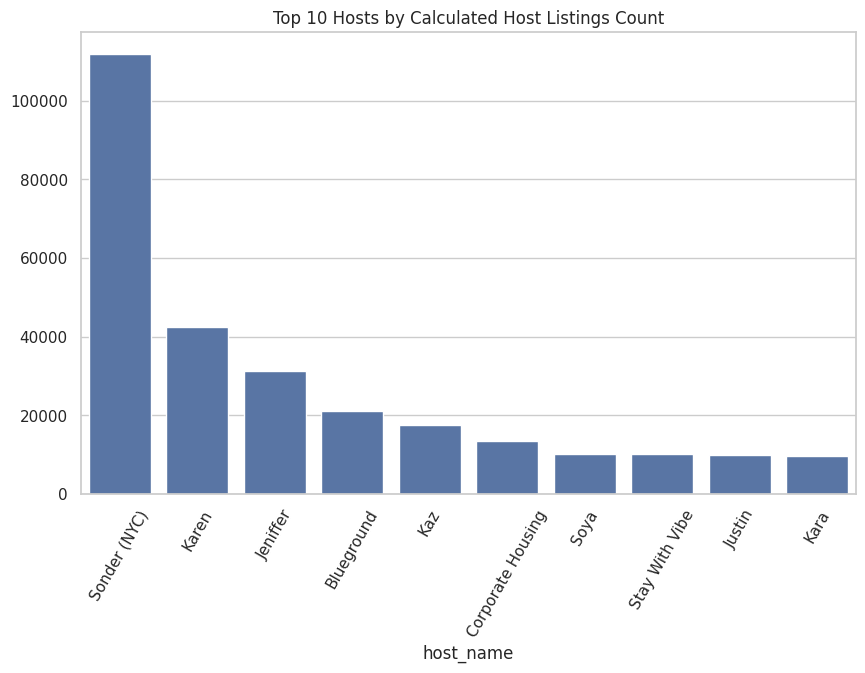

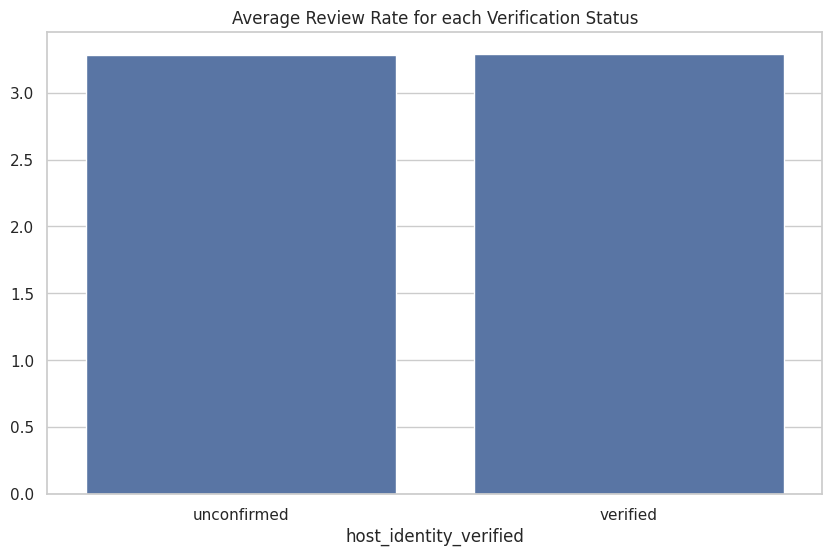

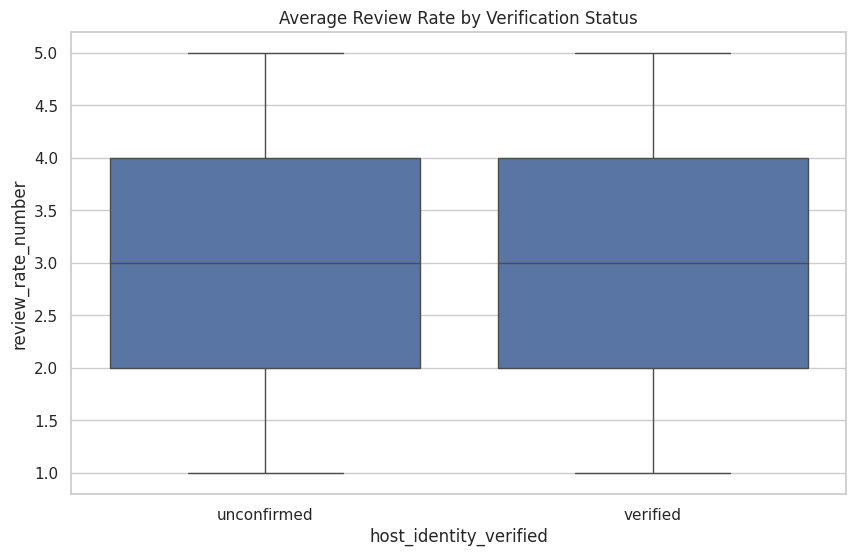

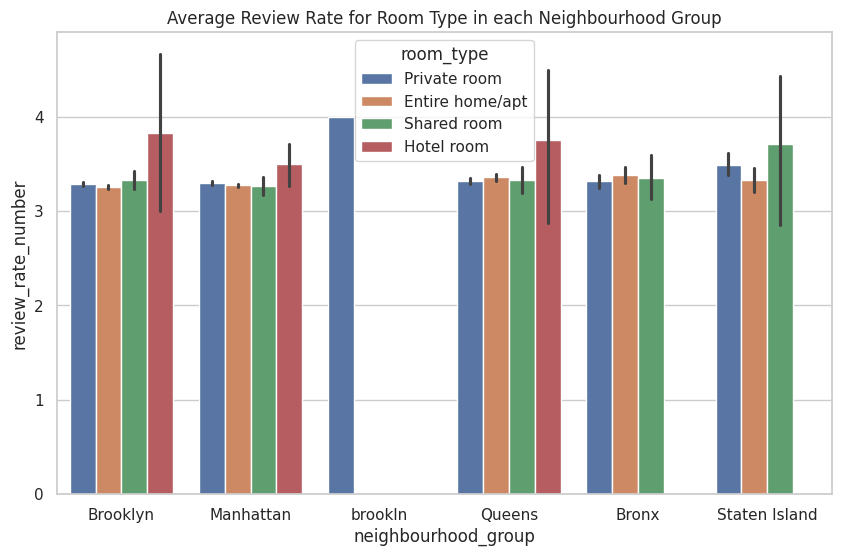

Correlation (Price vs Service Fee): 0.9999908997036285


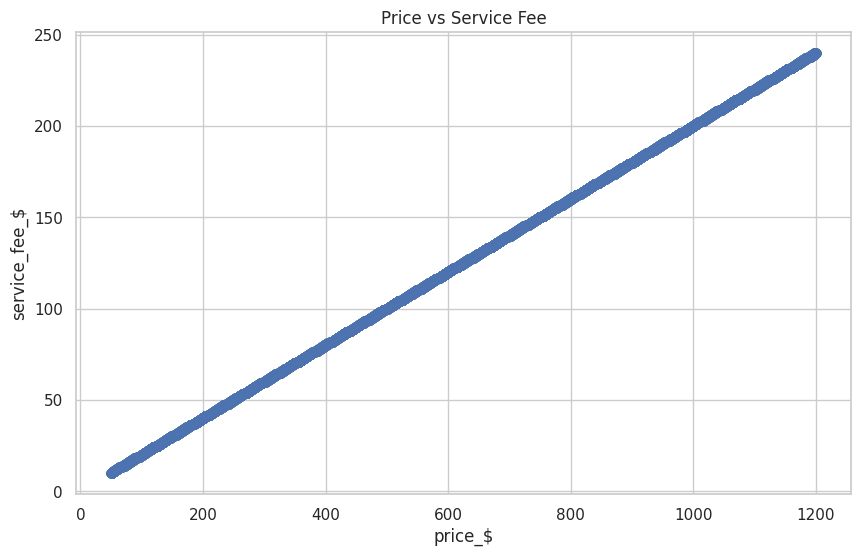

Correlation (Host Listings vs Availability): 0.14856264998419236


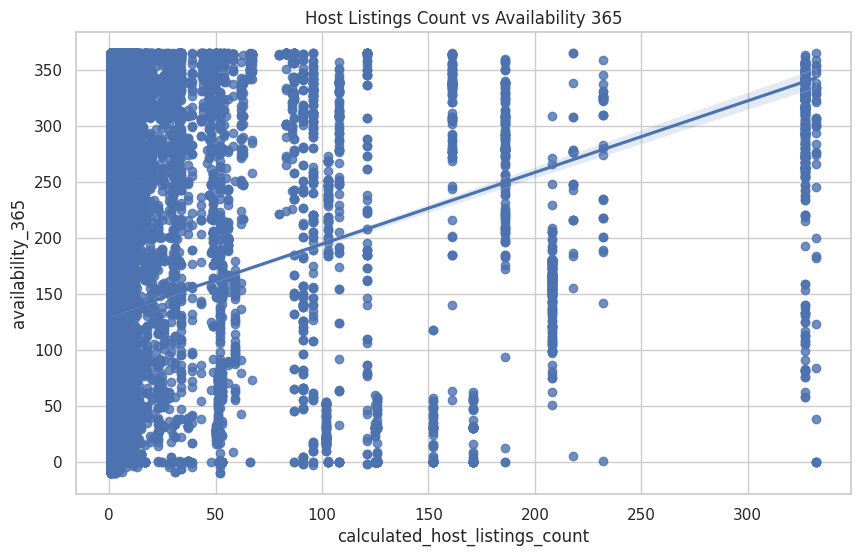

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# 📌 2. Load Dataset
df = pd.read_csv("/content/new.csv",  engine='python')

# 📌 3. Access Data
df.head()
df.info()
df.columns = df.columns.str.strip().str.lower()

# Fix common variations
rename_map = {
    "service fee": "service_fee",
    "room type": "room_type",
    "neighbourhood group": "neighbourhood_group",
    "neighborhood group": "neighbourhood_group",
    "neighbourhood": "neighbourhood",
    "host identity verified": "host_identity_verified",
    "host id": "host_id",
    "host name": "host_name",
    "availability 365": "availability_365",
    "review rate number": "review_rate_number",
    "construction year": "construction_year",
    "last review": "last_review",
    "calculated host listings count": "calculated_host_listings_count",
    "availability 365": "availability_365"
}
df.rename(columns=rename_map, inplace=True)


# Drop duplicate records
df.drop_duplicates(inplace=True)

# Drop columns with insufficient data
df.drop(['house_rules','license'], axis=1, inplace=True, errors="ignore")

# Remove $ and commas from price & service fee
df['price'] = df['price'].astype(str).str.replace('$','', regex=False).str.replace(',','', regex=False)
df['service_fee'] = df['service_fee'].astype(str).str.replace('$','', regex=False).str.replace(',','', regex=False)

# Convert to float
df['price_$'] = df['price'].astype(float)
df['service_fee_$'] = df['service_fee'].astype(float)

# Drop old columns
df.drop(['price','service_fee'], axis=1, inplace=True)

# Drop missing values
df.dropna(inplace=True)

# Convert data types
df['id'] = df['id'].astype(str)
df['host_id'] = df['host_id'].astype(str)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['construction_year'] = df['construction_year'].astype(int, errors='ignore')

# Correct spelling of neighbourhoods
df['neighbourhood_group'] = df['neighbourhood_group'].replace({'brooklin':'Brooklyn'})
df = df[df['availability_365'] <= 365]


# 1. Property Types Count
if "room_type" in df.columns:
    property_types = df['room_type'].value_counts()
    sns.barplot(x=property_types.index, y=property_types.values)
    plt.title("Property Types and their Count in the Dataset")
    plt.show()

# 2. Listings per Neighbourhood Group
if "neighbourhood_group" in df.columns:
    hood_group = df['neighbourhood_group'].value_counts()
    sns.barplot(x=hood_group.index, y=hood_group.values)
    plt.title("Which Neighbourhood Group has the Highest Number of Listings?")
    plt.show()

# 3. Average Price by Neighbourhood Group
if "neighbourhood_group" in df.columns and "price_$" in df.columns:
    avg_price = df.groupby('neighbourhood_group')['price_$'].mean().sort_values(ascending=False)
    sns.barplot(x=avg_price.index, y=avg_price.values)
    plt.title("Average Price per Listings ($) in each Neighbourhood Group")
    plt.show()

# 4. Average Price by Construction Year
if "construction_year" in df.columns and "price_$" in df.columns:
    avg_price_year = df.groupby('construction_year')['price_$'].mean()
    plt.plot(avg_price_year.index, avg_price_year.values)
    plt.title("Average Price ($) for Properties in each Construction Year")
    plt.show()

# 5. Top 10 Hosts by Calculated Host Listings Count
if "host_name" in df.columns and "calculated_host_listings_count" in df.columns:
    top_hosts = df.groupby('host_name')['calculated_host_listings_count'].sum().nlargest(10)
    sns.barplot(x=top_hosts.index, y=top_hosts.values)
    plt.xticks(rotation=60)
    plt.title("Top 10 Hosts by Calculated Host Listings Count")
    plt.show()

# 6. Review Rate by Host Verification
if "host_identity_verified" in df.columns and "review_rate_number" in df.columns:
    review_ver = df.groupby('host_identity_verified')['review_rate_number'].mean()
    sns.barplot(x=review_ver.index, y=review_ver.values)
    plt.title("Average Review Rate for each Verification Status")
    plt.show()

    # Boxplot
    sns.boxplot(data=df, x='host_identity_verified', y='review_rate_number')
    plt.title("Average Review Rate by Verification Status")
    plt.show()

# 7. Average Review Rate by Neighbourhood Group & Room Type
if "neighbourhood_group" in df.columns and "room_type" in df.columns and "review_rate_number" in df.columns:
    sns.barplot(data=df, x='neighbourhood_group', y='review_rate_number', hue='room_type')
    plt.title("Average Review Rate for Room Type in each Neighbourhood Group")
    plt.show()


# Price vs Service Fee
if "price_$" in df.columns and "service_fee_$" in df.columns:
    print("Correlation (Price vs Service Fee):", df['price_$'].corr(df['service_fee_$']))
    sns.regplot(data=df, x='price_$', y='service_fee_$')
    plt.title("Price vs Service Fee")
    plt.show()

# Host Listings Count vs Availability
if "calculated_host_listings_count" in df.columns and "availability_365" in df.columns:
    print("Correlation (Host Listings vs Availability):",
          df['calculated_host_listings_count'].corr(df['availability_365']))
    sns.regplot(data=df, x='calculated_host_listings_count', y='availability_365')
    plt.title("Host Listings Count vs Availability 365")
    plt.show()